In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

df = pd.read_csv('cab_sau_final_data.csv')
df

,ITEM_KEY,PRICE_ZONE_NAME,FISCAL_YEAR,FISCAL_WEEK,TOTAL_DISCOUNT%,SALES_QUANTITY,GIVEN_PRICE,DATE
0,102246,ABQ,2020,1,4.260000,46,10.191732,2020-01-06
1,102246,ABQ,2020,2,5.250000,47,10.374428,2020-01-13
2,102246,ABQ,2020,3,6.090000,31,10.320569,2020-01-20
3,102246,ABQ,2020,4,8.790000,58,10.023980,2020-01-27
4,102246,ABQ,2020,5,4.473333,69,10.498301,2020-02-03
...,...,...,...,...,...,...,...,...
444488,96478,Wilmington,2023,31,6.440000,7,19.237143,2023-07-31
444489,96478,Wilmington,2023,32,4.000000,5,19.190000,2023-08-07
444490,96478,Wilmington,2023,33,0.000000,2,19.990000,2023-08-14
444491,96478,Wilmington,2023,34,10.780000,2,17.835000,2023-08-21


## Data Exploration and Understanding

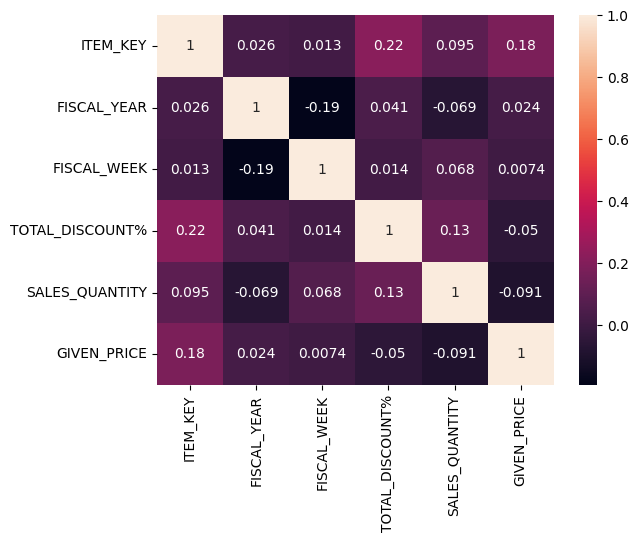

In [6]:
import seaborn as sns

# Correlation heatmap
sns.heatmap(df.drop(columns=['PRICE_ZONE_NAME', 'DATE']).corr(), annot=True)
plt.show()

In [7]:
num_of_items = df['ITEM_KEY'].unique().shape[0]
print('Number of items: ', num_of_items)

Number of items:  40


In [8]:
num_of_zones = df['PRICE_ZONE_NAME'].unique().shape[0]
print('Number of zones: ', num_of_zones)

Number of zones:  69


## Data Preprocessing

### Seperating the categorical and time series elements

We're going to have 3 input layers for our model. Two for the categorical data, and one for the time series data.

In [9]:
def preprocess(df, scaler, window_size=30, return_date=False):
    """
    Sorts the dataframe by FISCAL_YEAR and FISCAL_WEEK, normalizes SALES_QUANTITY, and stores the last 30 weeks of data for each item in each zone.
    """

    # Sort df by FISCAL YEAR and FISCAL WEEK
    df = df.sort_values(by=['FISCAL_YEAR', 'FISCAL_WEEK'])

    # Normalize SALES_QUANTITY
    df['SALES_QUANTITY'] = scaler.fit_transform(df['SALES_QUANTITY'].values.reshape(-1, 1)).flatten()

    # Store the last 30 weeks of data for each item in each zone
    windowed_data = []
    y = []

    for item in df['ITEM_KEY'].unique():
        for zone in df['PRICE_ZONE_NAME'].unique():

            # Temporary df for each item in each zone
            sq = df.loc[(df['ITEM_KEY'] == item) & (df['PRICE_ZONE_NAME'] == zone), 'SALES_QUANTITY']
            for i in range(window_size, len(sq)):

                # X
                row = [item, zone]
                row.extend(sq[i-window_size:i-1].values.tolist())
                windowed_data.append(row)

                # y
                y.append(sq.values[i])

    if return_date:
        return pd.DataFrame(windowed_data, columns=['FISCAL_YEAR', 'FISCAL_WEEK', 'ITEM_KEY', 'PRICE_ZONE_NAME', 't-29', 't-28', 't-27', 't-26', 't-25', 't-24', 't-23', 't-22', 't-21', 't-20', 't-19', 't-18', 't-17', 't-16', 't-15', 't-14', 't-13', 't-12', 't-11', 't-10', 't-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1']), pd.Series(y)

    return pd.DataFrame(windowed_data, columns=['ITEM_KEY', 'PRICE_ZONE_NAME', 't-29', 't-28', 't-27', 't-26', 't-25', 't-24', 't-23', 't-22', 't-21', 't-20', 't-19', 't-18', 't-17', 't-16', 't-15', 't-14', 't-13', 't-12', 't-11', 't-10', 't-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1']), pd.Series(y)

In [10]:
window_size = 30
scaler = StandardScaler()
X, y = preprocess(df, scaler, window_size)

In [22]:
X

,ITEM_KEY,PRICE_ZONE_NAME,t-29,t-28,t-27,t-26,t-25,t-24,t-23,t-22,...,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
0,102246,ABQ,-0.277140,-0.269676,-0.389104,-0.187569,-0.105462,-0.366711,-0.090534,-0.292069,...,-0.433889,-0.157712,-0.336854,-0.038284,-0.239819,-0.239819,-0.374175,-0.172641,-0.202498,-0.306997
1,102246,ABQ,-0.269676,-0.389104,-0.187569,-0.105462,-0.366711,-0.090534,-0.292069,-0.299533,...,-0.157712,-0.336854,-0.038284,-0.239819,-0.239819,-0.374175,-0.172641,-0.202498,-0.306997,-0.351783
2,102246,ABQ,-0.389104,-0.187569,-0.105462,-0.366711,-0.090534,-0.292069,-0.299533,-0.247283,...,-0.336854,-0.038284,-0.239819,-0.239819,-0.374175,-0.172641,-0.202498,-0.306997,-0.351783,-0.299533
3,102246,ABQ,-0.187569,-0.105462,-0.366711,-0.090534,-0.292069,-0.299533,-0.247283,-0.195033,...,-0.038284,-0.239819,-0.239819,-0.374175,-0.172641,-0.202498,-0.306997,-0.351783,-0.299533,-0.269676
4,102246,ABQ,-0.105462,-0.366711,-0.090534,-0.292069,-0.299533,-0.247283,-0.195033,0.073679,...,-0.239819,-0.239819,-0.374175,-0.172641,-0.202498,-0.306997,-0.351783,-0.299533,-0.269676,-0.254747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365184,184757,McAllen,-0.433889,-0.530924,-0.508532,-0.583174,-0.538389,-0.568246,-0.545853,-0.523460,...,-0.560781,-0.613031,-0.583174,-0.590638,-0.613031,-0.590638,-0.560781,-0.553317,-0.613031,-0.598103
365185,184757,McAllen,-0.530924,-0.508532,-0.583174,-0.538389,-0.568246,-0.545853,-0.523460,-0.598103,...,-0.613031,-0.583174,-0.590638,-0.613031,-0.590638,-0.560781,-0.553317,-0.613031,-0.598103,-0.583174
365186,184757,McAllen,-0.508532,-0.583174,-0.538389,-0.568246,-0.545853,-0.523460,-0.598103,-0.605567,...,-0.583174,-0.590638,-0.613031,-0.590638,-0.560781,-0.553317,-0.613031,-0.598103,-0.583174,-0.605567
365187,184757,McAllen,-0.583174,-0.538389,-0.568246,-0.545853,-0.523460,-0.598103,-0.605567,-0.598103,...,-0.590638,-0.613031,-0.590638,-0.560781,-0.553317,-0.613031,-0.598103,-0.583174,-0.605567,-0.605567


In [11]:
def train_test_split(X, y, test_size=0.05):
    X_train, X_test, y_train, y_test = None, None, None, None
    
    for item in tqdm(X['ITEM_KEY'].unique()):
        for zone in X['PRICE_ZONE_NAME'].unique():
            X_temp = X.loc[(X['ITEM_KEY'] == item) & (X['PRICE_ZONE_NAME'] == zone)]
            y_temp = y.loc[(X['ITEM_KEY'] == item) & (X['PRICE_ZONE_NAME'] == zone)]
            
            split_index = int(len(X_temp) * (1 - test_size))
            
            if X_train is None:
                X_train = X_temp.iloc[:split_index]
                X_test = X_temp.iloc[split_index:]
                y_train = y_temp.iloc[:split_index]
                y_test = y_temp.iloc[split_index:]
                continue

            X_train = pd.concat([X_train, X_temp.iloc[:split_index]])
            X_test = pd.concat([X_test, X_temp.iloc[split_index:]])
            y_train = pd.concat([y_train, y_temp.iloc[:split_index]])
            y_test = pd.concat([y_test, y_temp.iloc[split_index:]])
            
    return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = pd.get_dummies(X_train, columns=['ITEM_KEY', 'PRICE_ZONE_NAME'])
X_test = pd.get_dummies(X_test, columns=['ITEM_KEY', 'PRICE_ZONE_NAME'])

  0%|          | 0/40 [00:00<?, ?it/s]

In [13]:
num_of_items = X_train.columns[30:69].shape[0]
num_of_zones = X_train.columns[70:].shape[0]

In [23]:
print('Number of items: ', num_of_items)
print('Number of zones: ', num_of_zones)

Number of items:  39
Number of zones:  65


## Model Building

In [10]:
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, GRU, Dense, Dropout, Reshape, concatenate

# Define the input layers
item_input = Input(shape=(num_of_items,), name='item_key_input')
zone_input = Input(shape=(num_of_zones,), name='zone_name_input')
ts_input = Input(shape=(window_size-1,), name='ts_input')

# Dense layer for categorical features
d1 = Dense(units=32, activation='relu', name='item_dense_1')(item_input)
d2 = Dense(units=64, activation='relu', name='zone_dense_1')(zone_input)

# Reshape ts_input for GRU layer
ts_input = Reshape((window_size-1, 1))(ts_input)

# GRU layer for time series data
ts_gru = GRU(units=64, dropout=0.3, return_sequences=True, name='ts_gru')(ts_input)
ts_gru = GRU(units=32, dropout=0.2, return_sequences = True, name='ts_gru2')(ts_gru)
ts_gru = GRU(units=16, dropout=0.1, name='ts_gru3')(ts_gru)

# Concatenate the outputs of the embedding layers and GRU layer
concatenated = concatenate([d1, d2, ts_gru], name='concatenated')

# Dense layers for the rest of your model
x = Dense(256, activation='relu')(concatenated)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(16, activation='relu')(x)
output = Dense(1, activation='linear')(x)

# Create the model
model = Model(inputs=[item_input, zone_input, ts_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 29, 1)]      0           []                               
                                                                                                  
 ts_gru (GRU)                   (None, 29, 64)       12864       ['input_1[0][0]']                
                                                                                                  
 item_key_input (InputLayer)    [(None, 39)]         0           []                               
                                                                                                  
 zone_name_input (InputLayer)   [(None, 65)]         0           []                               
                                                                                              

In [12]:
model.fit(
    [X_train.iloc[:,30:69], X_train.iloc[:,70:], X_train.iloc[:,:29]],
    y_train,
    batch_size=32,
    epochs=15,
)

Epoch 1/15
10790/10790 [==============================] - 217s 19ms/step - loss: 0.3288
Epoch 2/15
10790/10790 [==============================] - 203s 19ms/step - loss: 0.3043
Epoch 3/15
10790/10790 [==============================] - 215s 20ms/step - loss: 0.2949
Epoch 4/15
10790/10790 [==============================] - 201s 19ms/step - loss: 0.2868
Epoch 5/15
10790/10790 [==============================] - 224s 21ms/step - loss: 0.2856
Epoch 6/15
10790/10790 [==============================] - 216s 20ms/step - loss: 0.2846
Epoch 7/15
10790/10790 [==============================] - 241s 22ms/step - loss: 0.2806
Epoch 8/15
10790/10790 [==============================] - 230s 21ms/step - loss: 0.2799
Epoch 9/15
10790/10790 [==============================] - 228s 21ms/step - loss: 0.2767
Epoch 10/15
10790/10790 [==============================] - 230s 21ms/step - loss: 0.2736
Epoch 11/15
10790/10790 [==============================] - 241s 22ms/step - loss: 0.2672
Epoch 12/15
10790/10790 [=====

In [17]:
import tensorflow as tf

model = tf.keras.models.load_model('item_loc_model.h5')

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# MSE and MAE on the training set
y_pred = model.predict([X_train.iloc[:,30:69], X_train.iloc[:,70:], X_train.iloc[:,:29]])
print('MSE on the training set: ', mean_squared_error(y_train, y_pred))
print('MAE on the training set: ', mean_absolute_error(y_train, y_pred))

# MSE and MAE on the test set
y_pred = model.predict([X_test.iloc[:,30:69], X_test.iloc[:,70:], X_test.iloc[:,:29]])
print('MSE on the test set: ', mean_squared_error(y_test, y_pred))
print('MAE on the test set: ', mean_absolute_error(y_test, y_pred))

10790/10790 [==============================] - 116s 10ms/step
MSE on the training set:  0.2575640177210619
MAE on the training set:  0.27084046327730715
623/623 [==============================] - 5s 9ms/step
MSE on the test set:  0.10309690280054055
MAE on the test set:  0.2186716111846089


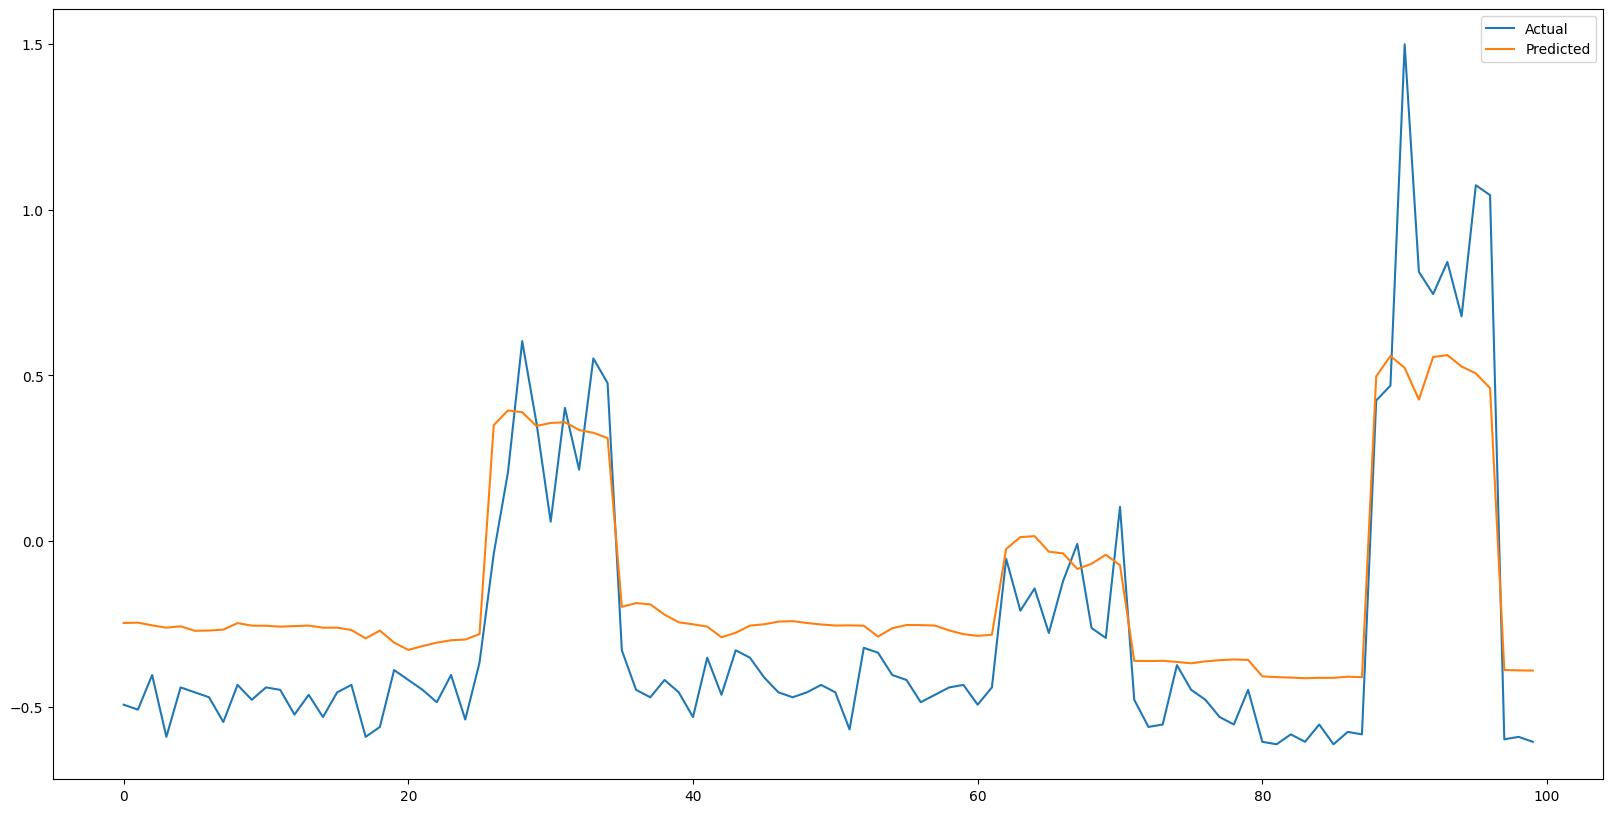

In [21]:
# Visualisation of predictions vs actual values
plt.figure(figsize=(20, 10))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.legend()
plt.show()

In [14]:
model.save('model.h5')